<a href="https://colab.research.google.com/github/kennedynjoroge/Algorithmic-Forex-Trading/blob/master/Forex_Algorithmic_Trading_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forex Algorithmic Trading Prediction


## 1.0 Defining the question
### Objective
Predict the highest and lowest price of the candle in the next upcoming hour.

### Metric for success
- Accuracy of predicted highest and lowest price.
- Cummulative net profit of the orders based on predicted signals.
- Number of won/lost orders

### Understanding the context
Foreign Exchange(FOREX) is the global market that allows the exchange of one currency for another. 5.3 trillion dollars worth of forex are traded daily. The forex market is open 24 hours a day and 5 days a week, only closing down during the weekend. The day starts when traders wake up in Sydney then moves to Tokyo, London, Frankfurt and finally, New York, before trading starts all over again in Sydney!

Buying a currency is buying a share in a particular country. The price of the currency is usually a direct reflection of the market’s opinion on the current and future health of its respective economy.

Forex trading is the simultaneous buying of one currency and selling another. Currencies are traded through a broker or dealer, and are traded in pairs e.g USD/JPY(US dollars/Japanese Yen).

The forex market is a decentralized global network of trading partners, including banks, public and private institutions, retail dealers, speculators, and central banks in-volved in the business of buying and selling money. Trades can take place anywhere as long as you have an Internet connection! While forex market has commercial and financial transactions as part of the trading volume, 90% currency trading is based on speculation. 

You would buy the pair if you believe the base currency will appreciate (gain value) relative to the quote currency.
You would sell the pair if you think the base currency will depreciate (lose value) relative to the quote currency.

90% of retail buyers lose money due to making of wrong decision. Therebeing, objective is to use machine learning to increase the chances of making a profit.
More info about forex trading available here -> https://www.babypips.com/learn/forex/

### Data Source
- Forex Capital Markets(FXCM), is a retail broker. Python wrapper API utilized to extract historical bid(sell) and ask(buy) data for USD/JPY instrument.
Historical data is useful for detailed examination of a market's past behaviour, traders and investors can gain perspective on the inner workings of that market.

- Quandl a marketplace for financial, economic data. Python wrapper API utilized to extract fundamental datasets i.e interest and employment rates.


### Assumptions
- Data from demo/sandbox is similar to production.
- Currency and Fundamental data e.g interest rates is valid.

## 2.0 Libraries and Data Importation



### Import Libraries


In [1]:
import datetime  as dt # Import data as date time
import pytz #Convert UTC to GMT+3
import numpy as np
import pandas as pd
import plotly.graph_objects as go 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

#Imputation
from sklearn.impute import KNNImputer

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#LSTM modelling libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm_notebook
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import mean_squared_error
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
## FXCM API - for importing currencies
# API definition https://www.fxcm.com/fxcmpy/appendix.html
!pip  install fxcmpy -q 
!pip install python-socketio -q 
import fxcmpy
# api token/key
api = fxcmpy.fxcmpy(config_file='fxcm.cfg')


In [0]:
## Quandl API - for fundamanetal data import e.g interest rate, employment rate.
# API Definition https://www.quandl.com/data/FRED-Federal-Reserve-Economic-Data/documentation
!pip install quandl -q 
import quandl
# api token/key
quandl.ApiConfig.api_key = "Y4Z_EXQ7qh7xxJhC8J6E"

In [0]:
# Ensure all columns are displayed
pd.pandas.set_option('display.max_rows', None)

### Import Bid and Ask Historical Data

Import historical bid and ask currency prices data. Will import 10 data for 10 years for starters. If need be, the years will be increased to enhance model accuracy by providing more data to make it able to generalize better.

Dataset is hourly candle data. Candlesticks describe the price action during the given time frame.

In [5]:
data_201920 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2019, 3, 30), stop = dt.datetime(2020, 3, 30))
data_201819 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2018, 3, 30), stop = dt.datetime(2019, 3, 30))
data_201718 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2017, 3, 30), stop = dt.datetime(2018, 3, 30))
data_201617 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2016, 3, 30), stop = dt.datetime(2017, 3, 30))
data_201516 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2015, 3, 30), stop = dt.datetime(2016, 3, 30))
data_201415 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2014, 3, 30), stop = dt.datetime(2015, 3, 30))
data_201314 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2013, 3, 30), stop = dt.datetime(2014, 3, 30))
data_201213 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2012, 3, 30), stop = dt.datetime(2013, 3, 30))
data_201112 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2011, 3, 30), stop = dt.datetime(2012, 3, 30))
data_201011 = api.get_candles('USD/JPY', period = 'H1', start = dt.datetime(2010, 3, 30), stop = dt.datetime(2011, 3, 30))

#Concatenate data for all the 10 years
years_list = [data_201920, data_201819, data_201718, data_201617, data_201516, data_201415, data_201314, data_201213, data_201112, data_201011]
df = pd.concat(years_list)

#Print Count
print("Count of hourly records per year \n")
print("2019-2020 - ",len(data_201920))
print("2018-2019 - ",len(data_201819))
print("2017-2018 - ",len(data_201718))
print("2016-2017 - ",len(data_201617))
print("2015-2016 - ",len(data_201516))
print("2014-2015 - ",len(data_201415))
print("2013-2014 - ",len(data_201314))
print("2012-2013 - ",len(data_201213))
print("2011-2012 - ",len(data_201112))
print("2010-2011 - ",len(data_201011))
print("\n Merged Data",len(df))

#View Sample
print("\n Sample Records From the DataFrame Before and After Time Conversion")
print(df.head(5)) # Before time convertsion
df = df.tz_localize("UTC").tz_convert('Africa/Nairobi').tz_localize(None)
df.head(5)

Count of hourly records per year 

2019-2020 -  6300
2018-2019 -  6315
2017-2018 -  6331
2016-2017 -  6331
2015-2016 -  6360
2014-2015 -  6304
2013-2014 -  6295
2012-2013 -  6217
2011-2012 -  6281
2010-2011 -  6247

 Merged Data 62981

 Sample Records From the DataFrame Before and After Time Conversion
                     bidopen  bidclose  bidhigh  ...  askhigh   asklow  tickqty
date                                             ...                           
2019-03-31 18:00:00  110.847   110.954  110.993  ...  110.998  110.970      193
2019-03-31 19:00:00  110.954   111.007  111.018  ...  111.030  110.974      215
2019-03-31 20:00:00  111.007   111.013  111.091  ...  111.107  111.012      321
2019-03-31 21:00:00  111.013   110.932  111.041  ...  111.086  110.893     1320
2019-03-31 22:00:00  110.932   110.936  110.983  ...  110.999  110.911     7250

[5 rows x 9 columns]


bidopen  bidclose  bidhigh  ...  askhigh   asklow  tickqty
date                                             ...                           
2019-03-31 21:00:00  110.847   110.954  110.993  ...  110.998  110.970      193
2019-03-31 22:00:00  110.954   111.007  111.018  ...  111.030  110.974      215
2019-03-31 23:00:00  111.007   111.013  111.091  ...  111.107  111.012      321
2019-04-01 00:00:00  111.013   110.932  111.041  ...  111.086  110.893     1320
2019-04-01 01:00:00  110.932   110.936  110.983  ...  110.999  110.911     7250

[5 rows x 9 columns]

Each row represents a candle of data for a single hour per day for USD/JPY currency pair.

a) Date - Date and hour. Date is originally in UTC/GMT. It's converted to GMT+3 local time

b) BID PRICES - Price that retailer trader sells at

- Bid open - price at the start of the candle

- Bid close - price at the end of the candle

- Bid high - highest price during the candle window

- Bid low - lowest price during the candle window

c) ASK PRICES - Price that retailer trader buys at

- Ask open - price at the start of the candle

- Ask close - price at the end of the candle

- Ask high - highest price during the candle window

- Ask low - lowest price during the candle window

d) Ticket Qty -  number of price changes that occured within the candle boundaries. It does not tell when the changes occured or how big or small the changes were.

In [6]:
df.describe()

bidopen      bidclose  ...        asklow        tickqty
count  62981.000000  62981.000000  ...  62981.000000   62981.000000
mean     101.711437    101.711665  ...    101.647278    7700.089503
std       13.966758     13.966725  ...     13.959214    8652.604880
min       75.671000     75.671000  ...     75.575000       1.000000
25%       88.504000     88.504000  ...     88.413000    2204.000000
50%      106.290000    106.290000  ...    106.226000    5222.000000
75%      111.728000    111.728000  ...    111.676000   10288.000000
max      125.676000    125.676000  ...    125.617000  171038.000000

[8 rows x 9 columns]

## Fundamental Features

### Interest Rates

Read US and Japanese Interest rates for the last 10 years from quandl API

In [7]:
# Read US Interest rates from quandl for the last 10 years
# API frequency is daily
v_start_date = '2010-03-30'
v_end_date = '2020-03-30'
df_US_Interest_Rates = quandl.get("FRED/DFF", start_date=v_start_date, end_date=v_end_date,timezone='GMT+3')
df_US_Interest_Rates.columns = df_US_Interest_Rates.columns.str.replace('Value', 'US_Daily_Interest_Rate')
df_JPY_Interest_Rates = quandl.get("MOFJ/INTEREST_RATE_JAPAN_40Y", start_date=v_start_date, end_date=v_end_date,timezone='GMT+3')
df_JPY_Interest_Rates.columns = df_JPY_Interest_Rates.columns.str.replace('Value', 'JPY_Daily_Interest_Rate')

#Create transaction date from index
df['Transaction_Date'] = df.index.strftime('%Y-%m-%d')
df['Candle_Date'] = df.index
df_US_Interest_Rates['Transaction_Date']  = df_US_Interest_Rates.index.strftime('%Y-%m-%d')
df_JPY_Interest_Rates['Transaction_Date']  = df_JPY_Interest_Rates.index.strftime('%Y-%m-%d')

df_JPY_Interest_Rates[0:5]

JPY_Daily_Interest_Rate Transaction_Date
Date                                                
2010-03-30                    2.320       2010-03-30
2010-03-31                    2.308       2010-03-31
2010-04-01                    2.285       2010-04-01
2010-04-02                    2.258       2010-04-02
2010-04-05                    2.259       2010-04-05

In [8]:
# Check length of Japanese versus US interest rates
print(len(df_JPY_Interest_Rates), len(df_US_Interest_Rates))

2448 3654


Some Japanese interest rates missing compared to US interest rates. Imputation to be preferred based on nearest neigbour

### Merge Currency and Interest Data

In [9]:
# Merge Dataframe and  US interest rates
df = df.merge(df_US_Interest_Rates,on='Transaction_Date',how='left')
df.set_index("Candle_Date", inplace = True) 
df[0:3]

bidopen  bidclose  ...  Transaction_Date  US_Daily_Interest_Rate
Candle_Date                             ...                                          
2019-03-31 21:00:00  110.847   110.954  ...        2019-03-31                    2.43
2019-03-31 22:00:00  110.954   111.007  ...        2019-03-31                    2.43
2019-03-31 23:00:00  111.007   111.013  ...        2019-03-31                    2.43

[3 rows x 11 columns]

In [10]:
# Merge Dataframe and  Japan interest rates
df['Candle_Date'] = df.index
df = df.merge(df_JPY_Interest_Rates,on='Transaction_Date',how='left')
df.set_index("Candle_Date", inplace = True) 
df[0:20]

bidopen  ...  JPY_Daily_Interest_Rate
Candle_Date                   ...                         
2019-03-31 21:00:00  110.847  ...                      NaN
2019-03-31 22:00:00  110.954  ...                      NaN
2019-03-31 23:00:00  111.007  ...                      NaN
2019-04-01 00:00:00  111.013  ...                    0.601
2019-04-01 01:00:00  110.932  ...                    0.601
2019-04-01 02:00:00  110.936  ...                    0.601
2019-04-01 03:00:00  110.982  ...                    0.601
2019-04-01 04:00:00  111.075  ...                    0.601
2019-04-01 05:00:00  111.145  ...                    0.601
2019-04-01 06:00:00  111.118  ...                    0.601
2019-04-01 07:00:00  111.076  ...                    0.601
2019-04-01 08:00:00  111.010  ...                    0.601
2019-04-01 09:00:00  111.038  ...                    0.601
2019-04-01 10:00:00  111.061  ...                    0.601
2019-04-01 11:00:00  111.040  ...                    0.601
2019-04-01 12:00:00  111.005  ...                    0.601
2019-04-01 13:00:00  110.991  ...                    0.601
2019-04-01 14:00:00  110.948  ...                    0.601
2019-04-01 15:00:00  110.981  ...                    0.601
2019-04-01 16:00:00  110.932  ...                    0.601

[20 rows x 12 columns]

Impute missing Japanese Currency data

In [0]:
#Impute JPY Interest Rates Using KNN Imputer
JPY_Interest_rate = df['JPY_Daily_Interest_Rate'].values
JPY_Interest_rate = JPY_Interest_rate.reshape(-1, 1)
imputer = KNNImputer(n_neighbors=2)
df['JPY_Daily_Interest_Rate'] = imputer.fit_transform(JPY_Interest_rate)

In [12]:
df[0:10]

bidopen  ...  JPY_Daily_Interest_Rate
Candle_Date                   ...                         
2019-03-31 21:00:00  110.847  ...                 1.414048
2019-03-31 22:00:00  110.954  ...                 1.414048
2019-03-31 23:00:00  111.007  ...                 1.414048
2019-04-01 00:00:00  111.013  ...                 0.601000
2019-04-01 01:00:00  110.932  ...                 0.601000
2019-04-01 02:00:00  110.936  ...                 0.601000
2019-04-01 03:00:00  110.982  ...                 0.601000
2019-04-01 04:00:00  111.075  ...                 0.601000
2019-04-01 05:00:00  111.145  ...                 0.601000
2019-04-01 06:00:00  111.118  ...                 0.601000

[10 rows x 12 columns]

### Unemployment rates

In [13]:
#  % of Total Labor Force. API Frequency is annual. 
US_Unemployment_percent = quandl.get("ODA/JPN_LUR", start_date=v_start_date, end_date=v_end_date)
JPY_Unemployment_percent = quandl.get("ODA/USA_LUR", start_date=v_start_date, end_date=v_end_date)
# quandl.get("ODA/USA_LUR", authtoken="Y4Z_EXQ7qh7xxJhC8J6E")
print("Japanese Unemployment rate: ",len(JPY_Unemployment_percent), " US_Unemployment_percent: ",len(US_Unemployment_percent))
US_Unemployment_percent

Japanese Unemployment rate:  10  US_Unemployment_percent:  10


Value
Date             
2010-12-31  5.058
2011-12-31  4.583
2012-12-31  4.325
2013-12-31  4.008
2014-12-31  3.583
2015-12-31  3.375
2016-12-31  3.108
2017-12-31  2.817
2018-12-31  2.442
2019-12-31  2.433

## Feature Engineering

Extract date time features from date

In [0]:
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

In [15]:
df[0:10]

bidopen  bidclose  bidhigh  ...  month  day  hour
Candle_Date                                      ...                  
2019-03-31 21:00:00  110.847   110.954  110.993  ...      3   31    21
2019-03-31 22:00:00  110.954   111.007  111.018  ...      3   31    22
2019-03-31 23:00:00  111.007   111.013  111.091  ...      3   31    23
2019-04-01 00:00:00  111.013   110.932  111.041  ...      4    1     0
2019-04-01 01:00:00  110.932   110.936  110.983  ...      4    1     1
2019-04-01 02:00:00  110.936   110.982  110.995  ...      4    1     2
2019-04-01 03:00:00  110.982   111.075  111.080  ...      4    1     3
2019-04-01 04:00:00  111.075   111.145  111.175  ...      4    1     4
2019-04-01 05:00:00  111.145   111.118  111.179  ...      4    1     5
2019-04-01 06:00:00  111.118   111.076  111.120  ...      4    1     6

[10 rows x 17 columns]

In [0]:
##Spread
#A spread is the price difference between where a trader may purchase or sell an underlying asset. 
df['spread']= df['askclose'] - df['bidclose']

## Bid Close Return
# References: https://quant.stackexchange.com/questions/21092/calculating-log-returns-across-multiple-securities-and-time , https://stackoverflow.com/questions/31742545/python-calculating-log-returns-of-a-time-series
# NB: In Quantitative Finance, doing your math in log-returns considered good manners
df['bid_close_return'] = np.log(df['bidclose']/df['bidclose'].shift(1))

## Bid Close Up or Down
#Was the bid close price up or down
df['bid_close_up_down'] = np.where(df['bid_close_return'] >0 ,1,0) # Bid Close went up or down?

##Simple Moving Average
df['bid_close_rolling_mean_1'] = df['bidclose'].rolling(window=20).mean()
df['bid_close_rolling_mean_2'] = df['bidclose'].rolling(window=50).mean()

## Bid High Return
# References: https://quant.stackexchange.com/questions/21092/calculating-log-returns-across-multiple-securities-and-time , https://stackoverflow.com/questions/31742545/python-calculating-log-returns-of-a-time-series
# NB: In Quantitative Finance, doing your math in log-returns considered good manners
df['bid_high_return'] = np.log(df['bidhigh']/df['bidhigh'].shift(1))

## Bid Close Up or Down
#Was the bid close price up or down
df['bid_high_up_down'] = np.where(df['bid_high_return'] >0 ,1,0) # Bid Close went up or down?

##Simple Moving Average
df['bid_high_rolling_mean_1'] = df['bidhigh'].rolling(window=20).mean()
df['bid_high_rolling_mean_2'] = df['bidhigh'].rolling(window=50).mean()

df['bid_high_next'] = df['bidhigh'].shift(1)

In [0]:
df['bid_high_rolling_mean_3'] = df['bidhigh'].rolling(window=120).mean()

In [17]:

df[0:10]

bidopen  bidclose  ...  bid_high_rolling_mean_2  bid_high_next
Candle_Date                             ...                                        
2019-03-31 21:00:00  110.847   110.954  ...                      NaN            NaN
2019-03-31 22:00:00  110.954   111.007  ...                      NaN        110.993
2019-03-31 23:00:00  111.007   111.013  ...                      NaN        111.018
2019-04-01 00:00:00  111.013   110.932  ...                      NaN        111.091
2019-04-01 01:00:00  110.932   110.936  ...                      NaN        111.041
2019-04-01 02:00:00  110.936   110.982  ...                      NaN        110.983
2019-04-01 03:00:00  110.982   111.075  ...                      NaN        110.995
2019-04-01 04:00:00  111.075   111.145  ...                      NaN        111.080
2019-04-01 05:00:00  111.145   111.118  ...                      NaN        111.175
2019-04-01 06:00:00  111.118   111.076  ...                      NaN        111.179

[10 rows x 27 columns]

## Exploratory Data Analysis

### Data Cleaning

a) Missing records

In [0]:
df.dropna(how="any",inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62932 entries, 2019-04-02 22:00:00 to 2011-03-30 03:00:00
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bidopen                   62932 non-null  float64
 1   bidclose                  62932 non-null  float64
 2   bidhigh                   62932 non-null  float64
 3   bidlow                    62932 non-null  float64
 4   askopen                   62932 non-null  float64
 5   askclose                  62932 non-null  float64
 6   askhigh                   62932 non-null  float64
 7   asklow                    62932 non-null  float64
 8   tickqty                   62932 non-null  int64  
 9   Transaction_Date          62932 non-null  object 
 10  US_Daily_Interest_Rate    62932 non-null  float64
 11  JPY_Daily_Interest_Rate   62932 non-null  float64
 12  year                      62932 non-null  int64  
 13  quarter                   

b) Duplicate records

In [0]:
pass

c) Outliers

In [0]:
pass

###  Univariate Analysis

a) Candlesticks for the last 10 years

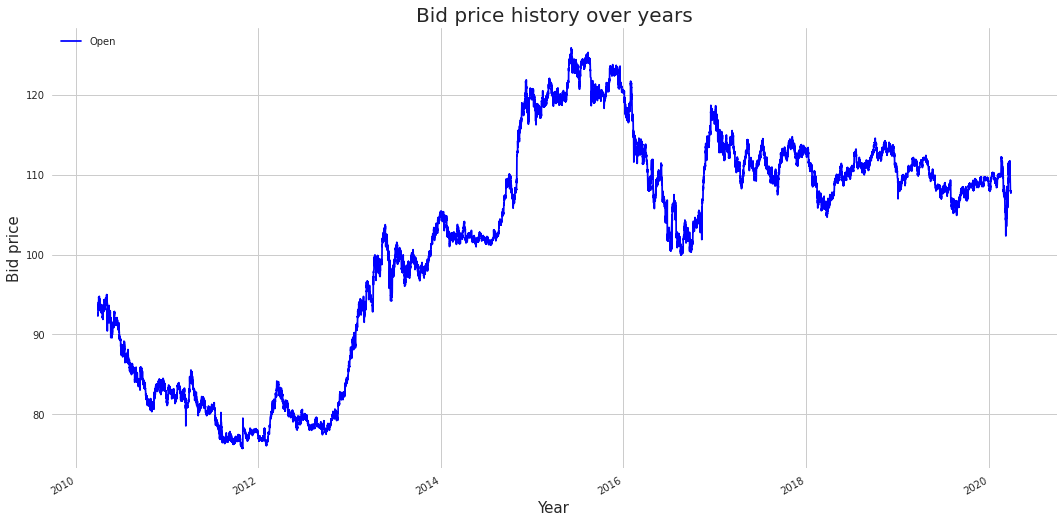

In [60]:
plt.figure(figsize = (18,9))
#plt.plot(df.index,df['bidhigh'],color='b',label='True')
#df['bidopen'].plot(color='red',label='True')
df['bidhigh'].plot(color='blue',label='True')
#df['bidlow'].plot(color='b',label='True')
#df['bidclose'].plot(color='',label='True')
#df['bid_high_rolling_mean_3'].plot(color='red',label='True')
# plt.plot(df['bidopen'])
# plt.plot(df['bidhigh'])
# plt.plot(df['bidlow'])
# plt.plot(df["bidclose"])
plt.title('Bid price history over years', fontsize =20)
plt.ylabel('Bid price', fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

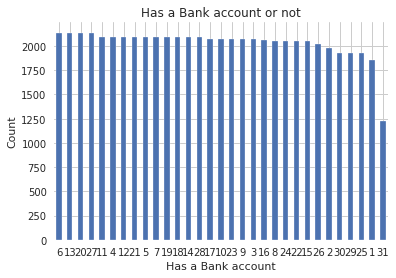

In [57]:
df['day'].value_counts().plot.bar(rot =0)
plt.xlabel("Has a Bank account")
plt.ylabel("Count")
plt.title("Has a Bank account or not")
plt.show()

In [23]:
#Create Plot
fig = go.Figure(data=[go.Candlestick(x=df.index,open=df['bidopen'],high=df['bidhigh'],low=df['bidlow'],close=df['bidclose'])])
#Specify title and y axis
fig.update_layout( title='Forex Pricing Patterns for last 10 years',yaxis_title='Price',xaxis_title='Year')
fig.show(renderer = "colab",auto_open=True)
# fig.write_html('tmp.html', auto_open=True)

Price was lowest in 2012 and highest in 2016


b) High, Low Prices Line Plot

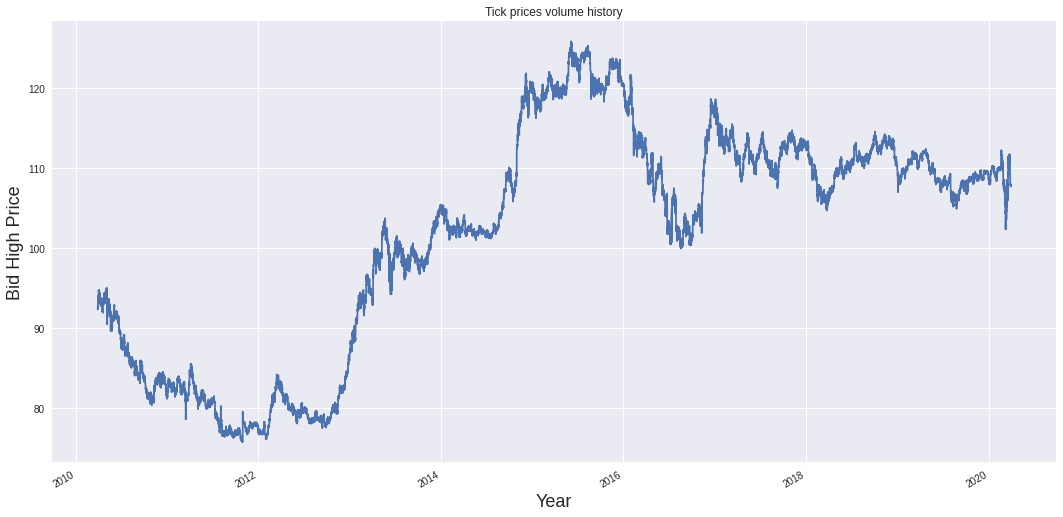

In [24]:
plt.figure(figsize = (18,9))
df['bidhigh'].plot()
plt.title('Tick prices volume history')
plt.xlabel('Year',fontsize=18)
plt.ylabel('Bid High Price',fontsize=18)
plt.show()

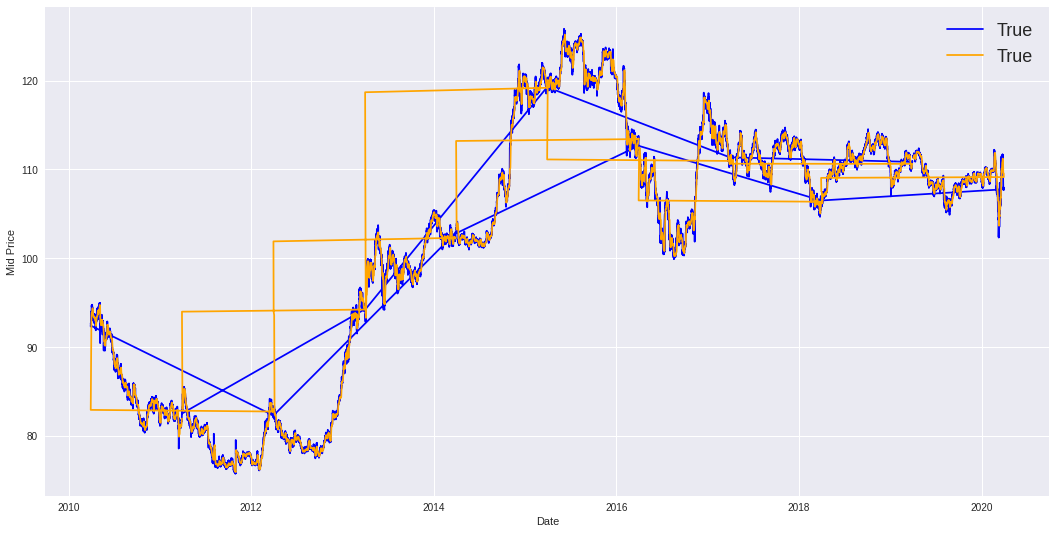

In [25]:
plt.figure(figsize = (18,9))
plt.plot(df.index,df['bidhigh'],color='b',label='True')
plt.plot(df.index,df['bid_high_rolling_mean_2'],color='orange',label='True')
#plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
#plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Tick Prices Volume History

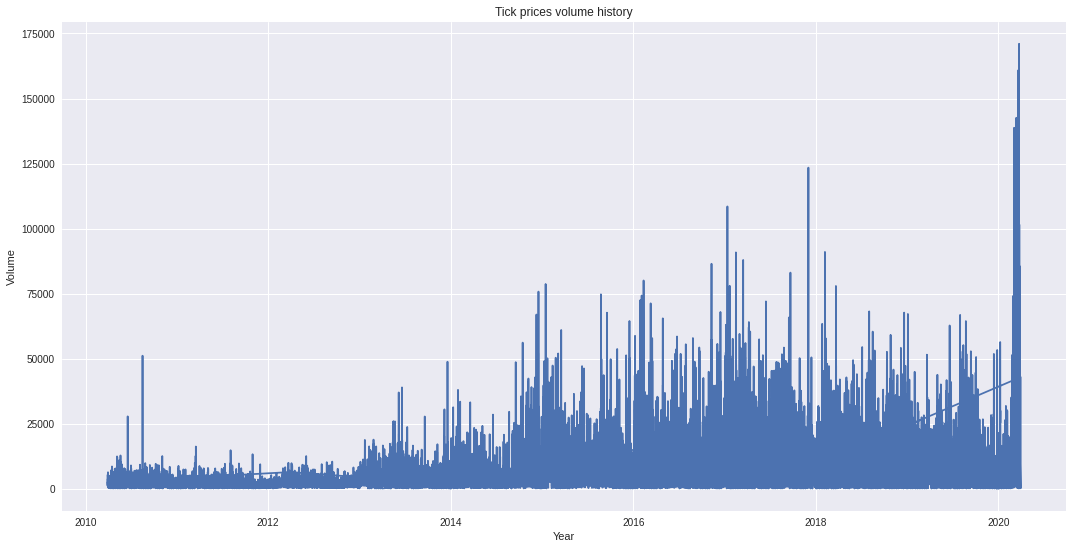

In [26]:
plt.figure(figsize = (18,9))
plt.plot(df["tickqty"])
#plt.plot(df.index,df['bidhigh'],color='red',label='True')
#plt.plot(df.index,df['bid_high_rolling_mean_2'],color='orange',label='True')
#plt.plot(df['bidhigh'],color='red',label='True')
plt.title('Tick prices volume history')
plt.ylabel('Volume')
plt.xlabel('Year')
plt.show()

Busiest Hour

Year Distribution

Quarter Distribution

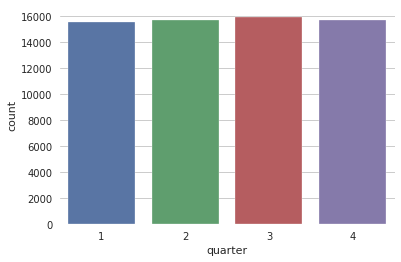

In [27]:
sns.set_style('whitegrid')
sns.countplot(df['quarter'])
plt.show()

Month Distribution

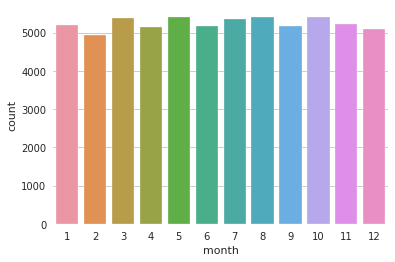

In [28]:
sns.set_style('whitegrid')
sns.countplot(df['month'])
plt.show()

Day Distribution

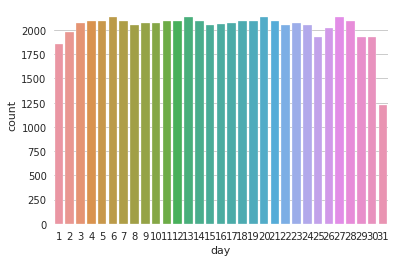

In [29]:
sns.set_style('whitegrid')
sns.countplot(df['day'])
plt.show()

Hour Distribution

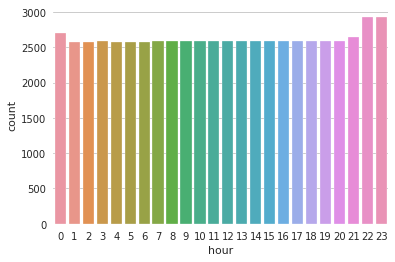

In [30]:
sns.set_style('whitegrid')
sns.countplot(df['hour'])
plt.show()

## Bivariate Analysis

Correlation

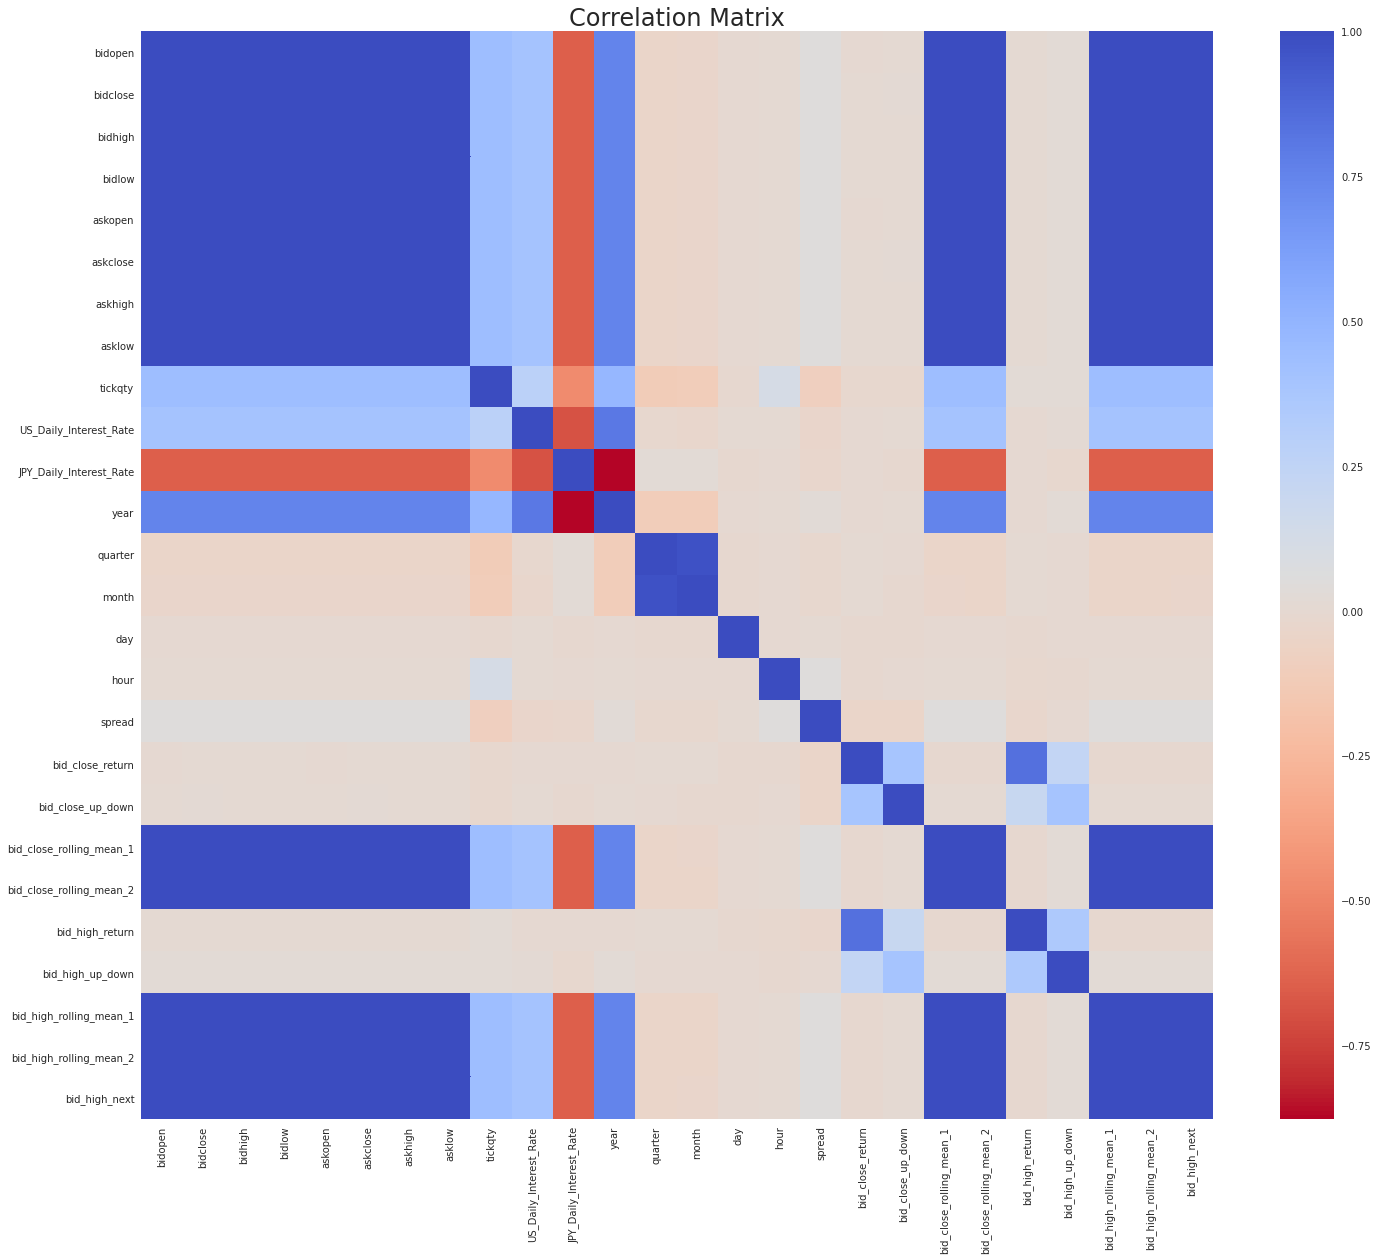

In [31]:
# Calculate pearson correlation coefficience
corr = df.corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title("Correlation Matrix", fontsize=24)
plt.show()

## Multivariate Analysis

## Pre-Modelling Steps

a) Normality Test

In [0]:
# Drop  non-required columns
#df = df.drop(['Transaction_Date'], axis=1)

## Modelling

The model should be able to:
- Identify trends as early as possible.
- Avoid one from getting whipsawed 

### a) Support Vector Machine
- Check with Radial as well versus linear and compare results


In [0]:
columns = ['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose',
       'askhigh', 'asklow', 'tickqty', 'US_Daily_Interest_Rate', 'JPY_Daily_Interest_Rate', 'year', 'quarter',
       'month', 'day', 'hour', 'spread', 'bid_close_return',
       'bid_close_up_down', 'bid_close_rolling_mean_1',
       'bid_close_rolling_mean_2', 
       'bid_high_rolling_mean_1', 'bid_high_rolling_mean_2', 'bid_high_next']
labels = df['bid_high_up_down'].values #bid_high_next 'bid_close_return',  'bid_high_up_down'
features = df[list(columns)].values

min_max = MinMaxScaler()
newfeatures = min_max.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(newfeatures, labels, test_size=0.1)

In [34]:
clf = svm.SVC(kernel='linear')
clf = clf.fit(X_train, y_train)

accuracy = clf.score(X_train, y_train)
print (' training data accuracy ', accuracy*100)

accuracy = clf.score(X_test, y_test)
print (' testing data accuracy ', accuracy*100)

ypredict = clf.predict(X_train)
print ('\n Training classification report\n', classification_report(y_train, ypredict))

ypredict = clf.predict(X_test)
print ('\n Testing classification report\n', classification_report(y_test, ypredict))

 training data accuracy  69.93184787598432
 testing data accuracy  68.8592310136638

 Training classification report
               precision    recall  f1-score   support

           0       0.74      0.68      0.71     30468
           1       0.66      0.72      0.69     26170

    accuracy                           0.70     56638
   macro avg       0.70      0.70      0.70     56638
weighted avg       0.70      0.70      0.70     56638


 Testing classification report
               precision    recall  f1-score   support

           0       0.73      0.67      0.69      3341
           1       0.65      0.72      0.68      2953

    accuracy                           0.69      6294
   macro avg       0.69      0.69      0.69      6294
weighted avg       0.69      0.69      0.69      6294



Arima

In [0]:
from statsmodels.tsa.arima_model import ARIMA

Gradient Boosting

### b) LSTM

LSTMs selected as it's frequently used to model time series forecasting problems.

Specify dependent and independent variables, scale and split

### Split and Scale the Features

In [36]:
cols = ['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose',
       'askhigh', 'asklow', 'tickqty', 'US_Daily_Interest_Rate', 'JPY_Daily_Interest_Rate', 'year', 'quarter',
       'month', 'day', 'hour', 'spread', 'bid_close_return',
       'bid_close_up_down', 'bid_close_rolling_mean_1',
       'bid_close_rolling_mean_2', 'bid_high_up_down',
       'bid_high_rolling_mean_1', 'bid_high_rolling_mean_2','bid_high_next']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,cols])

Train and Test size 50345 12587


####  Convert data to time series.

Splits data into multiple samples where each sample has a specified number of time steps and the output is a dependent and independent variable time steps input output.

In [0]:
#Parameters
params = {
    "batch_size": 20,  
    "lstm_mod_epochs": 100, # Increasing epochs from 30 higher noted to reduce variance. TO test 100, 200 and 300.
    "lr": 0.0001,
    "time_steps": 20 #changed from 60 to 600 to increase to change timestep from <3 days to 20 days
}

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

bid_price_high_column_idx =24

def build_timeseries(forex_data, y_col_index, time_steps):
    """
    y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(forex_data) - time steps
    """
    dim_0 = forex_data.shape[0] - time_steps
    dim_1 = forex_data.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = forex_data[i:time_steps+i]
        y[i] = forex_data[time_steps+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(forex_data, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = forex_data.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        print("Number of rows to drop:", no_of_rows_drop)
        return forex_data[:-no_of_rows_drop]
    else:
        return forex_data

Create the 3 features required as inputs to the LSTM models

In [38]:
## Train data time series split
# Label: 24 is the bid high price for next hour.
# Independent variables: x_train is the scaled training data
# Timesteps is units of how back in time the network should see.
x_train_time_series, y_train_time_series = build_timeseries(x_train, bid_price_high_column_idx, TIME_STEPS)
x_train_time_series = trim_dataset(x_train_time_series, BATCH_SIZE)
print("X Train: Trimmed Batch size: ",x_train_time_series.shape)

y_train_time_series = trim_dataset(y_train_time_series, BATCH_SIZE)
print("Y Train: Trimmed Batch size: ",y_train_time_series.shape)

## Test data set timeseries split
x_test_time_series, y_test_time_series = build_timeseries(x_test, 3, params["time_steps"])
#Split the data into test and validation by half
x_val, x_test_t = np.split(trim_dataset(x_test_time_series, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_test_time_series, BATCH_SIZE),2)


length of time-series i/o (50325, 20, 25) (50325,)
Number of rows to drop: 5
X Train: Trimmed Batch size:  (50320, 20, 25)
Number of rows to drop: 5
Y Train: Trimmed Batch size:  (50320,)



length of time-series i/o (12567, 20, 25) (12567,)
Number of rows to drop: 7
Number of rows to drop: 7


Splits the train and test data into 3 dimenstional array. 

-> Batch Size - how many samples of input will Neural Net see before updating the weights.

-> Time Steps define how many units back in time you want the network to see.

-> Features is the number of attributes used to represent each time step.


In [39]:
# Define an LSTM sequential model
#ACTION: Consider adding more LSTM layers. Had added but was getting dimension error on second layer.
def create_model(batch_size,time_steps,features):
  model = Sequential()
  model.add(LSTM(100, batch_input_shape=(batch_size, time_steps, features), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform')) #return_sequences=True,
  model.add(Dropout(0.4))
  model.add(Dense(20,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  opt = RMSprop(lr=params["lr"])
  model.compile(loss='mean_squared_error', optimizer=opt) #,metrics=['accuracy']
  return model

model = create_model(BATCH_SIZE,TIME_STEPS,x_train_time_series.shape[2])

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (20, 100)                 50400     
_________________________________________________________________
dropout (Dropout)            (20, 100)                 0         
_________________________________________________________________
dense (Dense)                (20, 20)                  2020      
_________________________________________________________________
dense_1 (Dense)              (20, 1)                   21        
Total params: 52,441
Trainable params: 52,441
Non-trainable params: 0
_________________________________________________________________


Fit the Model

In [40]:
#Log results to a file.
csv_logger = CSVLogger('training log')

# Early stopping :Monitor model performance on a validation set and stop training when performance degrades.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)

# Save model best model as 'save_best_only=True'
mcp = ModelCheckpoint(os.path.join("best_model.h5"), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)

history = model.fit(x_train_time_series, y_train_time_series, epochs=params["lstm_mod_epochs"] , verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp,csv_logger])
#return history

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.08244, saving model to best_model.h5
2516/2516 - 9s - loss: 0.0025 - val_loss: 0.0824
Epoch 2/100

Epoch 00002: val_loss improved from 0.08244 to 0.05079, saving model to best_model.h5
2516/2516 - 8s - loss: 0.0011 - val_loss: 0.0508
Epoch 3/100

Epoch 00003: val_loss improved from 0.05079 to 0.03460, saving model to best_model.h5
2516/2516 - 9s - loss: 8.6576e-04 - val_loss: 0.0346
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.03460
2516/2516 - 9s - loss: 7.6418e-04 - val_loss: 0.0366
Epoch 5/100

Epoch 00005: val_loss improved from 0.03460 to 0.02416, saving model to best_model.h5
2516/2516 - 9s - loss: 6.9235e-04 - val_loss: 0.0242
Epoch 6/100

Epoch 00006: val_loss improved from 0.02416 to 0.02322, saving model to best_model.h5
2516/2516 - 9s - loss: 6.3016e-04 - val_loss: 0.0232
Epoch 7/100

Epoch 00007: val_loss improved from 0.02322 to 0.02135, saving model to best_model.h5
2516/2516 - 9s - loss: 6.2260e-04 - 

Validation loss decreasing with increase in epochs.

1st epoch - 14%

10th Epoch - 10%

100th Epoch 0.004

To eliminate overfitting, to consider:

- Increasing dropout rate

- Reducing the number of epochs

- Linear activation

To increase model fitting speed, reduce the timesteps. Increasing to 600 from 30 considerably increases the run speed.

Visualize Training Accuracy and Loss History

In [41]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


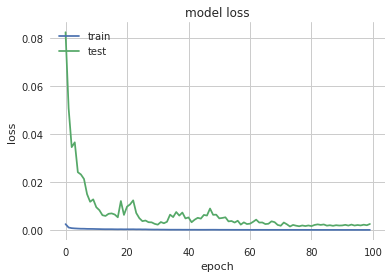

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Get model Prediction

In [43]:
print(len(y_pred))
print(len(x_test_t))
print(len(y_test_t))

NameError: ignored

Error is 0.00022293748528995615 (6280,) (6280,)
[0.13349043 0.13543676 0.13735795 0.13940343 0.14013189 0.1426013
 0.14250973 0.14048453 0.13874686 0.13868201 0.13818005 0.13606994
 0.13754031 0.14028457 0.13760678]
[0.11817976 0.11910803 0.12038699 0.12001568 0.12042824 0.11826227
 0.11440477 0.11527116 0.11597252 0.1153743  0.11564247 0.11589001
 0.11768468 0.11830353 0.11679766]
[83.596214 83.69057  83.7837   83.88286  83.918175 84.03788  84.03345
 83.93527  83.85103  83.847885 83.823555 83.72126  83.79254  83.925575
 83.79576 ]
[82.854 82.899 82.961 82.943 82.963 82.858 82.671 82.713 82.747 82.718
 82.731 82.743 82.83  82.86  82.787]


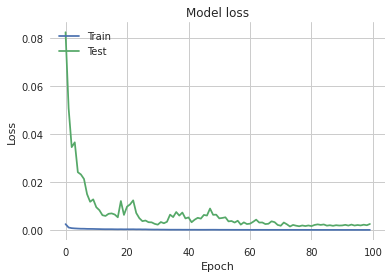

In [45]:
#Prediction
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()

y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# Convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

#### View actual output

In [0]:
#plt.figure()
plt.figure(figsize = (18,9))
plt.plot(y_pred)
#plt.plot(y_test_t)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
#plt.legend(['Prediction', 'Real'], loc='upper left')

In [0]:
#plt.figure()
plt.figure(figsize = (18,9))
plt.plot(y_pred)
plt.plot(y_test_t)
plt.title('Prediction vs Real Stock Price', fontsize=20)
plt.ylabel('Bid Price', fontsize=16)
plt.xlabel('Price Instances', fontsize=16)
plt.legend(['Prediction', 'Real'], loc='upper right', fontsize=16)
plt.show()

In [0]:
diff = y_pred_org - y_test_t_org
df_pred = pd.Series(y_pred_org,y_test_t_org,diff)
df_pred
diff

In [0]:
df_pred

In [0]:
df_test